In [1]:
!pip install torch
!pip install torchvision

    100% |████████████████████████████████| 591.8MB 33kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x61998000 @  0x7ff8496d32a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 2.9MB/s 
    100% |████████████████████████████████| 2.0MB 14.7MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random 

import torch
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

from scipy import io
import pandas as pd


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
df_asd = pd.read_csv(r"drive/My Drive/THUMOS/thumos14-human-searches.csv")
df_asd.head(5)

,search-id,step-id,time,video-id,target-action
0,0,0,340.806,video_validation_0000413,JavelinThrow
1,0,1,333.616,video_validation_0000413,JavelinThrow
2,0,2,332.897,video_validation_0000413,JavelinThrow
3,0,3,331.459,video_validation_0000413,JavelinThrow
4,0,4,330.740,video_validation_0000413,JavelinThrow


In [5]:
df_asd_4 = df_asd[(df_asd['target-action'] == "JavelinThrow")]
df_asd_4.head(5)

,search-id,step-id,time,video-id,target-action
0,0,0,340.806,video_validation_0000413,JavelinThrow
1,0,1,333.616,video_validation_0000413,JavelinThrow
2,0,2,332.897,video_validation_0000413,JavelinThrow
3,0,3,331.459,video_validation_0000413,JavelinThrow
4,0,4,330.740,video_validation_0000413,JavelinThrow


In [6]:
videos_unique = df_asd_4['video-id'].unique()
videos_unique

array(['video_validation_0000413', 'video_validation_0000416',
       'video_validation_0000411', 'video_validation_0000415',
       'video_validation_0000412', 'video_validation_0000414',
       'video_validation_0000417', 'video_validation_0000418',
       'video_validation_0000420', 'video_validation_0000419'],
      dtype=object)

In [20]:
input_l = []
output_l = []

video_dict = {}
df = df_asd
for video in df['video-id'].unique() :
  print(video)
  video_dict[video] = []
  df_curr = df[(df['video-id'] == video)]
  seqs = df_curr['search-id'].unique()

  for seq in seqs :
    X = []
    y = []
#     print(seq)
    timestamps = df_curr[(df_curr['search-id'] == seq)]['time'].as_matrix()
    len_t = len(timestamps)
    for i in range(1, len_t, 1) :
      X.append(timestamps[i-1])
      y.append(timestamps[i] - timestamps[i-1])
  
    video_dict[video].append([X, y])


video_validation_0000413
video_validation_0000262
video_validation_0000486
video_validation_0000931
video_validation_0000210
video_validation_0000484
video_validation_0000151
video_validation_0000782
video_validation_0000206
video_validation_0000163
video_validation_0000157
video_validation_0000369
video_validation_0000185
video_validation_0000281
video_validation_0000907
video_validation_0000205
video_validation_0000184
video_validation_0000901
video_validation_0000935
video_validation_0000267
video_validation_0000783
video_validation_0000785
video_validation_0000288
video_validation_0000181
video_validation_0000787
video_validation_0000178
video_validation_0000180
video_validation_0000905
video_validation_0000060
video_validation_0000489
video_validation_0000179
video_validation_0000365
video_validation_0000167
video_validation_0000857
video_validation_0000852
video_validation_0000786
video_validation_0000982
video_validation_0000177
video_validation_0000684
video_validation_0000906


In [9]:
import torchvision.models as models
resnet50 = models.resnet50(pretrained=True)
resnet50.avgpool = torch.nn.AdaptiveAvgPool2d(1)
visual_encoder = nn.Sequential(*list(resnet50.children())[:-1])
visual_encoder.cuda()
visual_encoder.eval()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:05<00:00, 18053951.71it/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1

In [0]:
duration_dict = {}
videos_considered = df['video-id'].unique()
for v in videos_considered:
    temp = cv2.VideoCapture("drive/My Drive/THUMOS/videos/"  + v + ".mp4")
    temp.set(cv2.CAP_PROP_POS_AVI_RATIO,1)
    duration = temp.get(cv2.CAP_PROP_POS_MSEC)
    duration_dict[v] = duration/1000

In [21]:

import cv2

lstm = nn.LSTM(256, 1000, num_layers = 1)
linear = nn.Linear(1000, 1)
hidden = (torch.randn(1, 1, 1000).cuda(),
          torch.randn(1, 1, 1000).cuda())

lstm_model = nn.Sequential(lstm, linear)
lstm_model.cuda()
lstm_model.train()
criterion = torch.nn.SmoothL1Loss().type(torch.cuda.FloatTensor)

optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)

for video in list(*[video_dict]) :
  print(video)
  cap = cv2.VideoCapture("drive/My Drive/THUMOS/Videos/" + str(video) + ".mp4")
  sequences = video_dict[video]
  for ttt, seq in enumerate(sequences) :
    print('New seq')
    [X, y] = seq
    sc = 0
    for x_i,y_i in zip(X,y) :
      sc = sc + 1
      lstm_model.zero_grad()
 
      cap.set(cv2.CAP_PROP_POS_MSEC,  x_i * 1000)
      ret, frame = cap.read()

      img = np.rollaxis(frame, 2, 0)   

      
      t = torch.from_numpy(img)
      x_var = Variable(t.unsqueeze(0).float().cuda())

      output = visual_encoder(x_var).data.cpu().numpy() 
      op = output.reshape(-1, 16)

      mean, eigvec = cv2.PCACompute(op, mean=None, maxComponents = 64)

      op = eigvec.reshape(1, 1, -1)
      t2 = torch.from_numpy(op)
      x_var2 = Variable(t2.float().cuda())

      out_lstm, hidden = lstm_model[0](x_var2, hidden)
      preds = lstm_model[1](out_lstm)

    
      loss = criterion(y_i, preds)
      if (ttt % 1000 == 0) :
        print("true : %f , pred : %f  loss : %f" % (y_i, preds, loss))

      optimizer.zero_grad()
      loss.backward(retain_graph=True)
      optimizer.step()
      if (sc > 250) :
        print('break')
        break
      
    out_lstm.detach_()
    hidden = (torch.randn(1, 1, 1000).cuda(), torch.randn(1, 1, 1000).cuda())

      
#       y_i
        
      

video_validation_0000413
New seq
true : -7.190000 , pred : 0.024280  loss : 6.714280
true : -0.719000 , pred : -0.331465  loss : 0.075092
true : -1.438000 , pred : -0.645481  loss : 0.314043
true : -0.719000 , pred : -1.051214  loss : 0.055183
true : -1.438000 , pred : -1.169655  loss : 0.036005
true : -0.719000 , pred : -1.256609  loss : 0.144512
true : -1.438000 , pred : -1.354111  loss : 0.003519
true : -1.438000 , pred : -1.332265  loss : 0.005590
true : -0.719000 , pred : -1.245247  loss : 0.138468
true : -1.438000 , pred : -1.066736  loss : 0.068918
true : -0.719000 , pred : -0.604284  loss : 0.006580
true : -1.438000 , pred : -0.251149  loss : 0.686851
true : -0.719000 , pred : -0.445337  loss : 0.037446
true : -1.438000 , pred : -0.316826  loss : 0.621174
true : -1.438000 , pred : -0.176454  loss : 0.761546
true : -0.719000 , pred : -0.896741  loss : 0.015796
true : -1.438000 , pred : -1.538086  loss : 0.005009
true : -0.719000 , pred : -2.096535  loss : 0.877535
true : 0.71900

KeyboardInterrupt: ignored

In [11]:
lstm_model


Sequential(
  (0): LSTM(256, 1000)
  (1): Linear(in_features=1000, out_features=1, bias=True)
)

In [0]:
torch.save(lstm_model, 'drive/My Drive/lstm_model_t.h5')

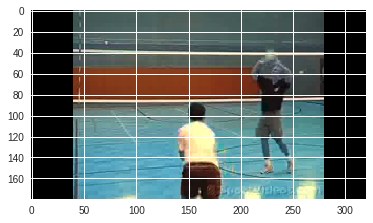

In [18]:
cap = cv2.VideoCapture("drive/My Drive/THUMOS/Videos/video_validation_0000990.mp4")
cap.set(cv2.CAP_PROP_POS_MSEC, (53.4) * 1000)
ret, frame = cap.read()


%matplotlib inline
from matplotlib import pyplot as plt
plt.imshow(frame)
plt.show()